In [1]:
from joint import read, crab_skymodel, plot_cube, get_likelihood, get_pred_cube
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

In [64]:
fname = "Fermi-LAT-3FHL_data_Fermi-LAT.fits"
fermi_hdul = read(fname)

# Log interpolation, center = (lo * hi)^0.5
energy_center = fermi_hdul["COUNTS_BANDS"].data.field(1) * u.TeV
energy_lo = fermi_hdul["COUNTS_BANDS"].data.field(2) * u.TeV
energy_hi = fermi_hdul["COUNTS_BANDS"].data.field(3) * u.TeV
# BANDS are the same for COUNTS, BKG, PSF, so just assign once here
exposure = fermi_hdul["EXPOSURE"].data
background = fermi_hdul["BACKGROUND"].data
counts = fermi_hdul["COUNTS"].data

# Read deltx and delty from FITS 
deltx = fermi_hdul["COUNTS"].header["CDELT1"] 
delty = fermi_hdul["COUNTS"].header["CDELT2"] 
dx_edges = np.linspace(-25, 25, 51) * u.degree * deltx
dy_edges = np.linspace(-20, 20, 41) * u.degree * delty
# Use averge value for position center coordinate
dx = (dx_edges[:-1] + dx_edges[1:]) / 2
dy = (dy_edges[:-1] + dy_edges[1:]) / 2
# test_likelihood = get_likelihood((energy_center, dx, dy), crab_skymodel, **test_parameter)
guess_parameter = {"prefactor": 1e-10, "index": -3.18, "sigma": 0.5 * u.degree}
guess_pred = get_pred_cube((energy_center, dx, dy), crab_skymodel,\
                            exposure, background, **guess_parameter)
guess_likelihood = get_likelihood(guess_pred, counts)
print(f"data: {get_likelihood(counts, counts):.3E}\n"
       f"guess: {guess_likelihood:.3E}")
# dx = np.arange()  
# dy = np.arange()  
# dx = np.linspace(-1, 1, 50) * u.degree
# dy = np.linspace(-1, 1, 40) * u.degree
# axes = (energy_center, dx, dy)
# pred_cube = crab_skymodel(axes, **test_parameter)
# test_slice = slice(5) 

# fig, axs = plot_cube(pred_cube, test_slice)
# axs[-1].lines[0].set_xdata(energy_center)
# axs[-1].set_xlim(energy_lo[0].value, energy_hi[-1].value)
# axs[-1].set_xlabel("TeV")
# fig.savefig(f"test_pred_cube_σ{sigma}.png", dpi=500)
# fig1, axs1 = plot_cube(background, test_slice)
# axs1[-1].lines[0].set_xdata(energy_center)
# axs1[-1].set_xlim(energy_lo[0].value, energy_hi[-1].value)
# axs1[-1].set_xlabel("TeV")
# fig1.savefig(f"test_bkg_cube_σ{sigma}.png", dpi=500)

# fig.savefig(f"test_pred_cube_σ{test_parameter["sigma"]}.png", dpi=500)

data: -3.022E+02
guess: -5.790E+05


## 使用scipy.optimize.minimize方法最优化

In [98]:
from scipy.optimize import minimize

def func(x):
    # 无量纲化
    
    keys=["prefactor", "index", "sigma"]
    guess_parameter=dict(zip(keys,x))
    test_dx,test_dy=np.asarray(dx),np.asarray(dy)    
    
    guess_pred = get_pred_cube((energy_center, test_dx,test_dy), crab_skymodel,\
                            exposure, background, **guess_parameter)
    guess_likelihood = get_likelihood(guess_pred, counts)
    return -guess_likelihood

In [137]:
x0=[1e-10,-3.18,0.2]
# Reference:
# https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
res = minimize(func, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 1091.209030
         Iterations: 128
         Function evaluations: 248


In [154]:
guess_parameter=dict(zip(keys,res.x))
guess_pred = get_pred_cube((energy_center, test_dx,test_dy), crab_skymodel,\
                            exposure, background, **guess_parameter)

Text(0.5, 1.0, 'real')

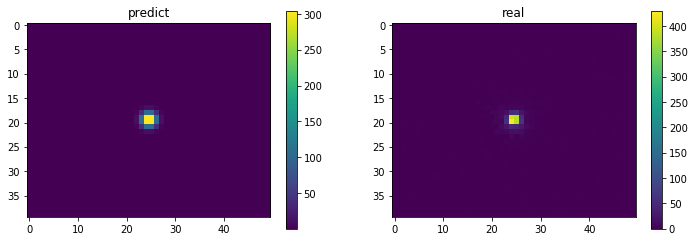

In [155]:
energy_index=2

fig=plt.figure(figsize=(12,4))
ax=plt.subplot(121)
#plt.imshow(guess_pred[energy_index])
plt.imshow(guess_pred.sum(axis=0))
plt.colorbar()
plt.title('predict')
ax=plt.subplot(122)
#plt.imshow(counts[energy_index])
plt.imshow(counts.sum(axis=0))
plt.colorbar()
plt.title('real')

10

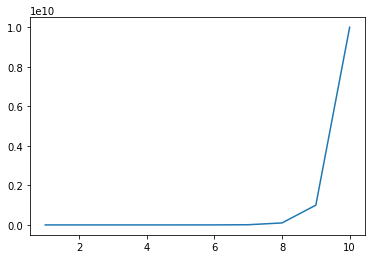

In [248]:
# y=np.logspace(1,10,10)
x=np.linspace(1,10,10)
plt.plot(x,y)
len(y)

In [250]:
class BaseGeomModel:
    '''
    Base class for geometry. 
    '''
    
    def __init__(self,skydir,width,binsz):
        self.skydir=skydir
        self.width=width
        self.binsz=binsz

        self.x_edge=np.arange(0,width[0]+binsz,binsz)-width[0]/2+skydir[0]
        self.y_edge=np.arange(0,width[1]+binsz,binsz)-width[1]/2+skydir[1]
        
        self.x_center=(self.x_edge[:-1]+self.x_edge[1:])/2
        self.y_center=(self.y_edge[:-1]+self.y_edge[1:])/2
        
class GaussianGeomModel(BaseGeomModel):
    '''
    Gaussian geometric Model
    '''
    
    def __init__(self,sigma,*args):
        self.sigma=sigma
        super().__init__(*args)

    @property
    def spatial(self):
        xx,yy=np.meshgrid(self.x_center,self.y_center)
        return np.exp(-(xx**2 + yy**2) / (2 * self.sigma**2))
    
    
class Axes:
    '''
    Base class for axes
    '''
    
    def __init__(self,width,name,interp,kind,num):
        self.width=width
        self.name=name
        self.interp=interp
        self.kind=kind
        self.num=num
        
        if kind=='log' & kind=='edge':
            self.bands=np.logspace(width[0],width[1],num)
            
        
class PowerLaw(Axes):
    '''
    
    '''
    
    def __init__(self,prefactor,index,sigma):
        self.prefactor=prefactor
        self.index=index
        self.parameters={'prefactor':prefactor,'index':index,'sigma':sigma}

class Map:
    
    def __init__(self,geom,axes):
        self.geom=geom
        self.axes=axes

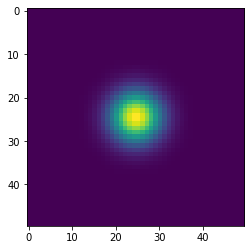

In [243]:
skydir=(0,0)
width=(5,5)
binsz=0.1

test_model=GaussianGeomModel(0.4,skydir,width,binsz)


plt.imshow(test_model.spatial)

In [234]:
test_model._spatial

array([[1.88170845e-055, 9.00113158e-057, 4.13685316e-058, ...,
        2.77755945e-136, 2.02737699e-138, 1.42178485e-140],
       [4.91445133e-055, 2.35082236e-056, 1.08042048e-057, ...,
        7.25414223e-136, 5.29489333e-138, 3.71327048e-140],
       [1.23317855e-054, 5.89889596e-056, 2.71108873e-057, ...,
        1.82027494e-135, 1.32864249e-137, 9.31767393e-140],
       ...,
       [1.23317855e-054, 5.89889596e-056, 2.71108873e-057, ...,
        1.82027494e-135, 1.32864249e-137, 9.31767393e-140],
       [4.91445133e-055, 2.35082236e-056, 1.08042048e-057, ...,
        7.25414223e-136, 5.29489333e-138, 3.71327048e-140],
       [1.88170845e-055, 9.00113158e-057, 4.13685316e-058, ...,
        2.77755945e-136, 2.02737699e-138, 1.42178485e-140]])

In [171]:
skydir=(10,0)
width=(5,5)
binsz=0.1

x_edge=np.arange(0,width[0],binsz)-width[0]/2+skydir[0]
y_edge=np.arange(0,width[1],binsz)-width[1]/2+skydir[1]



In [173]:
y_edge

array([-2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8, -1.7, -1.6, -1.5,
       -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4,
       -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,
        0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,
        1.9,  2. ,  2.1,  2.2,  2.3,  2.4])

In [157]:
dx_edges

<Quantity [ 2.5,  2.4,  2.3,  2.2,  2.1,  2. ,  1.9,  1.8,  1.7,  1.6,
            1.5,  1.4,  1.3,  1.2,  1.1,  1. ,  0.9,  0.8,  0.7,  0.6,
            0.5,  0.4,  0.3,  0.2,  0.1, -0. , -0.1, -0.2, -0.3, -0.4,
           -0.5, -0.6, -0.7, -0.8, -0.9, -1. , -1.1, -1.2, -1.3, -1.4,
           -1.5, -1.6, -1.7, -1.8, -1.9, -2. , -2.1, -2.2, -2.3, -2.4,
           -2.5] deg>

In [156]:
def read(fname):
    return fits.open(fname, mode="readonly")


def get_flux(hdulist, axes):
    pass

def model_fit(data, axes, model, optimizer):
    pass

def crab_skymodel(axes, prefactor, index, sigma):
    energy, delx, dely = axes

    def crab_spatial(delx, dely):
        return np.exp(-(delx**2 + dely**2) / (2 * sigma**2))

    def crab_spctral(energy):
        refernce_energy = 100 * u.GeV 
        return prefactor * (energy / refernce_energy)**index

    # TODO: order of meshgrid is not clear
    yy, ee, xx, = np.meshgrid(dely, energy, delx)
    return crab_spatial(xx, yy) * crab_spctral(ee)


def get_pred_cube(axes, model, exposure, background, **kwargs):
    return model(axes, **kwargs) * exposure + background


def get_likelihood(pred_cube, counts, **kwargs):
    pred_total = np.sum(pred_cube)
    # In order to avoid too large number for fatorial
    # use Stirling's Approximation here, which is 
    # ln(n!) = n * ln(n) - n (first order approximation)
    
    # Only elements greater than 10 is valid
    # TODO : use masked array to do condition slicing
    # counts_masked = np.ma.masked_array(counts, mask=mask_large)
    counts_masked = np.ma.masked_array(counts, mask=mask_large)
    mask_large = counts > 10

    counts_masked = counts.copy()
    counts_factorial = np.zeros_like(counts)
    counts_factorial[~mask_large] = np.log10(factorial(counts_masked[~mask_large]))
    counts_factorial[mask_large] = counts_masked[mask_large] * np.log10(counts_masked[mask_large]) \
                                            - counts_masked[mask_large] * np.log10(np.e) 
    # For a given bin range, data_fatorial is reusable
    data_factorial = np.sum(counts_factorial)
    # TODO : What if element in pred_cube equals zero?
    # To avoid zero division, add a tiny quantity to pred_cube
    log_like = np.sum(counts * np.log10(pred_cube + 1e-12)) - data_factorial
    log_like = -pred_total * np.log10(np.e) + log_like
    return log_like


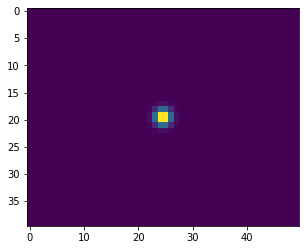

In [129]:
plt.imshow(guess_pred.sum(axis=0))

In [141]:
guess_pred.sum(axis=0).shape

(40, 50)

In [143]:
dy

<Quantity [-1.95, -1.85, -1.75, -1.65, -1.55, -1.45, -1.35, -1.25, -1.15,
           -1.05, -0.95, -0.85, -0.75, -0.65, -0.55, -0.45, -0.35, -0.25,
           -0.15, -0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,
            0.75,  0.85,  0.95,  1.05,  1.15,  1.25,  1.35,  1.45,  1.55,
            1.65,  1.75,  1.85,  1.95] deg>